In [1]:
import torchvision
import vision.transforms as T
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from PIL import ImageColor
from vision.engine import evaluate
import vision.utils as utils

from vision.coco_utils import get_coco_kp
from ochuman.ochuman_utils import ConvertOCHumanPolysToMask

In [2]:
transform = T.Compose([
  T.ToTensor()
])
dataset = get_coco_kp("coco", "val", transforms=transform)

loading annotations into memory...
Done (t=0.84s)
creating index...
index created!


In [3]:
from vitpose import ViTPose

vitpose = ViTPose()

No CUDA runtime is found, using CUDA_HOME='/mnt/beegfs/home/serre/l2rpn/miniconda3/envs/DL'


apex is not installed
apex is not installed
apex is not installed
Use load_from_local loader


In [4]:
from vitdet import ViTDet

vitdet = ViTDet().eval()
vitdet.load_state_dict(torch.load("weights/ViTDet_10epochs.pth", map_location=torch.device("cpu")))

[01/10 19:06:54 detectron2]: Rank of current process: 0. World size: 1
[01/10 19:06:54 detectron2]: Environment info:
---------------------  -----------------------------------------------------------------------------------------------
sys.platform           linux
Python                 3.9.15 (main, Nov  4 2022, 16:13:54) [GCC 11.2.0]
numpy                  1.23.4
detectron2             0.6 @/mnt/beegfs/home/serre/l2rpn/miniconda3/envs/DL/lib/python3.9/site-packages/detectron2
Compiler               GCC 13.0
CUDA compiler          not available
DETECTRON2_ENV_MODULE  <not set>
PyTorch                1.13.0 @/mnt/beegfs/home/serre/l2rpn/miniconda3/envs/DL/lib/python3.9/site-packages/torch
PyTorch debug build    False
GPU available          No: torch.cuda.is_available() == False
Pillow                 9.2.0
torchvision            0.14.0 @/mnt/beegfs/home/serre/l2rpn/miniconda3/envs/DL/lib/python3.9/site-packages/torchvision
fvcore                 0.1.5.post20221122
iopath              

<All keys matched successfully>

In [5]:
def plot_skeleton_kpts(im, out, person_threshold=0.7, kpt_threshold=6):
  colors = np.random.permutation(list(mcolors.CSS4_COLORS.values()))
  
  palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                        [230, 230, 0], [255, 153, 255], [153, 204, 255],
                        [255, 102, 255], [255, 51, 255], [102, 178, 255],
                        [51, 153, 255], [255, 153, 153], [255, 102, 102],
                        [255, 51, 51], [153, 255, 153], [102, 255, 102],
                        [51, 255, 51], [0, 255, 0], [0, 0, 255], [255, 0, 0],
                        [255, 255, 255]])

  skeleton = [[16, 14], [14, 12], [17, 15], [15, 13], [12, 13], [6, 12],
              [7, 13], [6, 7], [6, 8], [7, 9], [8, 10], [9, 11], [2, 3],
              [1, 2], [1, 3], [2, 4], [3, 5], [4, 6], [5, 7]]

  pose_limb_color = palette[[9, 9, 9, 9, 7, 7, 7, 0, 0, 0, 0, 0, 16, 16, 16, 16, 16, 16, 16]]
  pose_kpt_color = palette[[16, 16, 16, 16, 16, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9]]

  fig, ax = plt.subplots()
  ax.imshow(im.permute(1, 2, 0))

  if "masks" in out:
    for i, mask in enumerate(out["masks"]):
      if not "scores" in out or out["scores"][i] >= person_threshold:
        color = list(ImageColor.getcolor(colors[i], "RGB")) + [128]
        mask = np.repeat(mask.reshape(mask.shape[0], mask.shape[1], 1), 4, axis=2) * np.array(color)
        plt.imshow(mask)
  
  for _ in out["boxes"]:
    for i, box in enumerate(out["boxes"]):
      if not "scores" in out or out["scores"][i] >= person_threshold:
        rect=plt.Rectangle(box[:2], box[2], box[3], fill=False, color=colors[i])
        ax.add_patch(rect)

  for j, kpt in enumerate(out["keypoints"]):
    if not "scores" in out or out["scores"][j] >= person_threshold:
      for i, (x, y, v) in enumerate(kpt):
        if not "keypoints_scores" in out or out["keypoints_scores"][j][i] >= kpt_threshold:
          if v:
            color = pose_kpt_color[i] / 255
            circle = plt.Circle((x, y), 3, color=color)
            ax.add_patch(circle)

      for i, sk in enumerate(skeleton):
        color = pose_limb_color[i] / 255
        x1, y1, v1 = kpt[sk[0]-1]
        x2, y2, v2 = kpt[sk[1]-1]

        if not "keypoints_scores" in out or \
           (out["keypoints_scores"][j][sk[0]-1] >= kpt_threshold \
            and out["keypoints_scores"][j][sk[1]-1] >= kpt_threshold):

          if v1 and v2:
            line = plt.Line2D((x1, x2), (y1, y2), linewidth=2, color=color)
            ax.add_line(line)

  ax.set_axis_off()

In [6]:
while True:
  idx = np.random.randint(len(dataset))
  im, label = dataset[idx]
  if "keypoints" in label.keys():
    break
print(f"Image no: {idx}.")

Image no: 4810.


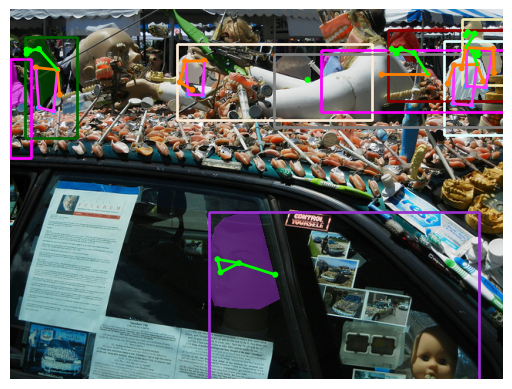

In [7]:
plot_skeleton_kpts(im, label)

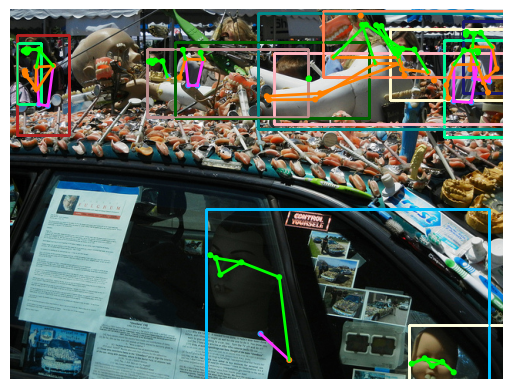

In [8]:
with torch.no_grad():
  vitdet_out = vitdet(im.unsqueeze(0))[0]
  
plot_skeleton_kpts(im, vitdet_out)

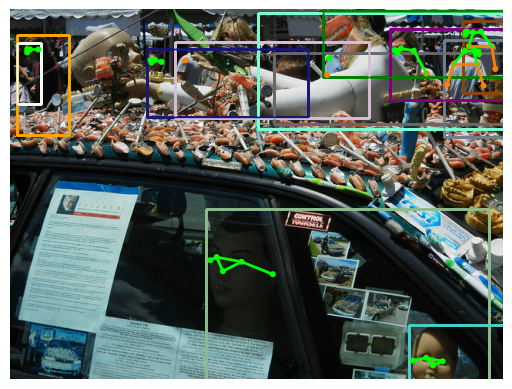

In [9]:
with torch.no_grad():
  out = vitpose(im.unsqueeze(0), [vitdet_out])[0]
  
plot_skeleton_kpts(im, out)

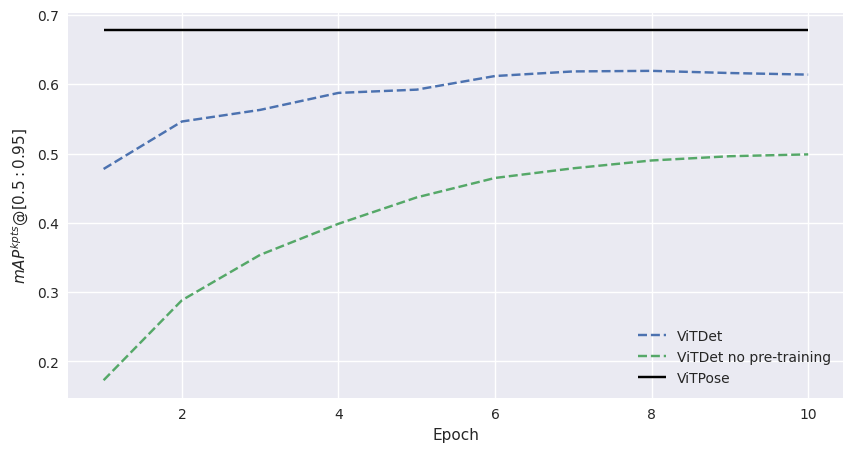

In [11]:
mAPs_kpts_noweights = np.load("figures/kpts_noweights.npy")
mAPs_kpts = np.load("figures/kpts.npy")
num_epochs = len(mAPs_kpts_noweights)

plt.style.use("seaborn-v0_8")
plt.figure(figsize=(10, 5))

plt.plot(range(1, num_epochs+1), mAPs_kpts, "--", label="ViTDet")
plt.plot(range(1, num_epochs+1), mAPs_kpts_noweights, "--", label="ViTDet no pre-training")
plt.hlines(0.678, 1, num_epochs, linestyles="solid", color="black", label="ViTPose")
plt.grid(True)
plt.ylabel("$mAP^{kpts}@[0.5:0.95]$")
plt.xlabel("Epoch")
plt.legend(loc="lower right")
plt.savefig("figures/mAPs_all_models.pdf")